In [ ]:
!pip install swig
!pip install gymnasium[box2d]
!pip install renderlab

  Using cached gymnasium-0.29.1-py3-none-any.whl (953 kB)
  Using cached Farama_Notifications-0.0.4-py3-none-any.whl (2.5 kB)
  Using cached box2d-py-2.3.5.tar.gz (374 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp310-cp310-linux_x86_64.whl size=2376173 sha256=c297f0a330838b180764ceb147bc783e036ee5d1d0d5e393a94032d8e4a84d55
  Stored in directory: /root/.cache/pip/wheels/db/8f/6a/eaaadf056fba10a98d986f6dce954e6201ba3126926fc5ad9e
Successfully built box2d-py


In [ ]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from typing import Sequence
from collections import namedtuple, deque
import itertools
import random
import warnings
import renderlab as rl
warnings.filterwarnings("ignore")

### Hyper-Parameters

In [ ]:
GAMMA = 0.99
BATCH_SIZE = 128
BUFFER_SIZE = 10000
MIN_REPLAY_SIZE = 5000
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 0.997
TARGET_UPDATE_FREQ = 5

## Standard DQN

In [ ]:
env = gym.make("LunarLander-v2", render_mode = "rgb_array")
obs = env.reset()
episode_reward = 0.0

In [ ]:
Transition = namedtuple('Transition', ('states', 'actions', 'rewards', 'dones', 'next_states'))

class Replay_memory():

    def __init__(self, env, fullsize, minsize, batchsize):
        self.env = env
        self.memory = deque(maxlen=fullsize)
        self.rewards = deque(maxlen=50)
        self.batchsize = batchsize
        self.minsize = minsize

    def append(self, transition):
        self.memory.append(transition)

    def sample_batch(self):
        batch = random.sample(self.memory, self.batchsize)
        batch = Transition(*zip(*batch))
        states = torch.from_numpy(np.array(batch.states, dtype=np.float32))
        actions = torch.from_numpy(np.array(batch.actions, dtype=np.int64)).unsqueeze(1)
        rewards = torch.from_numpy(np.array(batch.rewards, dtype=np.float32)).unsqueeze(1)
        dones = torch.from_numpy(np.array(batch.dones, dtype=np.bool8)).unsqueeze(1)
        next_states = torch.from_numpy(np.array(batch.next_states, dtype=np.float32))
        return states, actions, rewards, dones, next_states

    def initialize(self):
        obs, info = env.reset()
        for _ in range(self.minsize):
            action = self.env.action_space.sample()
            new_obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            transition = Transition(obs, action, reward, done, new_obs)
            self.append(transition)
            obs = new_obs
            if done:
                self.env.reset()
        return self

In [ ]:
replay_memory = Replay_memory(env, BUFFER_SIZE, MIN_REPLAY_SIZE, BATCH_SIZE).initialize()

In [ ]:
class DQN(nn.Module):
    def __init__(self, ninputs, noutputs):
        super(DQN, self).__init__()
        self.a1 = nn.Linear(ninputs, 64)
        self.a2 = nn.Linear(64, noutputs)

    def forward(self, X):
        o = self.a1(X)
        o = torch.tanh(o)
        o = self.a2(o)
        return o

    def __call__(self, X):
        return self.forward(X)

In [ ]:
dqn_policy = DQN(env.observation_space.shape[0], env.action_space.n)
dqn_target = DQN(env.observation_space.shape[0], env.action_space.n)
dqn_target.load_state_dict(dqn_policy.state_dict())
dqn_target.eval()

DQN(
  (a1): Linear(in_features=8, out_features=64, bias=True)
  (a2): Linear(in_features=64, out_features=4, bias=True)
)

In [ ]:
loss_fn = nn.SmoothL1Loss()
learning_rate = 0.001
optimizer = torch.optim.Adam(dqn_policy.parameters(), lr=learning_rate)

In [ ]:
def epsilon_greedy_policy(epsilon, obs):
    rnd_sample = random.random()
    if rnd_sample <= epsilon:
        action = env.action_space.sample()
    else:
        with torch.no_grad():
            action = int(torch.argmax(dqn_policy(torch.Tensor(obs))))
    return action

### Training

In [ ]:
obs, info = env.reset()
eps_threshold = EPS_START
episode = 1
episode_scores = []

for step in itertools.count():
    action = epsilon_greedy_policy(eps_threshold, obs)
    new_obs, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    replay_memory.append(Transition(obs, action, reward, done, new_obs))
    episode_reward += reward
    obs = new_obs

    if done:
        episode += 1
        eps_threshold = np.max((eps_threshold*EPS_DECAY, EPS_END))
        replay_memory.rewards.append(episode_reward)
        episode_scores.append(episode_reward)
        obs, info = env.reset()
        avg_res = np.mean(replay_memory.rewards)

        if episode % 100 == 0:
            avg_res = np.mean(replay_memory.rewards)
            print(f'Episode: {episode} Avg Results: {avg_res} Epsilon: {eps_threshold}')

        if avg_res >= 195:
            print(f'Solved at episode: {episode} Avg Results: {avg_res}')
            break
        episode_reward = 0

    b_states, b_actions, b_rewards, b_dones, b_next_states = replay_memory.sample_batch()

    qvalues = dqn_policy(b_states).gather(1, b_actions)

    with torch.no_grad():
        target_qvalues = dqn_target(b_next_states)
        max_target_qvalues = torch.max(target_qvalues, axis=1).values.unsqueeze(1)
        expected_qvalues = b_rewards + GAMMA * (1 - b_dones.type(torch.int64)) * max_target_qvalues

    loss = loss_fn(qvalues, expected_qvalues)
    optimizer.zero_grad()
    loss.backward()
    for param in dqn_policy.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

    if episode % TARGET_UPDATE_FREQ == 0:
        dqn_target.load_state_dict(dqn_policy.state_dict())

Episode: 100 Avg Results: -72.83524388903845 Epsilon: 0.6684411570569752
Episode: 200 Avg Results: -39.00555345067163 Epsilon: 0.49497015522925014
Episode: 300 Avg Results: 27.535061221710347 Epsilon: 0.3665176088892224
Episode: 400 Avg Results: 59.50841921008373 Epsilon: 0.2714005202266275
Episode: 500 Avg Results: 88.2941554393416 Epsilon: 0.2009678132587261
Episode: 600 Avg Results: 147.65710856165285 Epsilon: 0.14881350239221705
Episode: 700 Avg Results: 136.7965738325455 Epsilon: 0.11019405612842245
Solved at episode: 766 Avg Results: 200.27073719853277


In [ ]:
def build_video():
  obs, info = env.reset()

  while True:
    action = int(torch.argmax(dqn_policy(torch.Tensor(obs))))
    obs, reward, terminated, truncated, info = env.step(action)

    if terminated or truncated:
      break

  env.play()

In [ ]:
env = rl.RenderFrame(env, "./video")
build_video()

Moviepy - Building video temp-{start}.mp4.
Moviepy - Writing video temp-{start}.mp4



Moviepy - Done !
Moviepy - video ready temp-{start}.mp4


In [ ]:
def plot_scores(epsisode_scores):
  fig = plt.figure()
  ax = fig.add_subplot(111)
  plt.plot(np.arange(len(episode_scores)), episode_scores)
  plt.ylabel('Score')
  plt.xlabel('Episode #')
  plt.show()

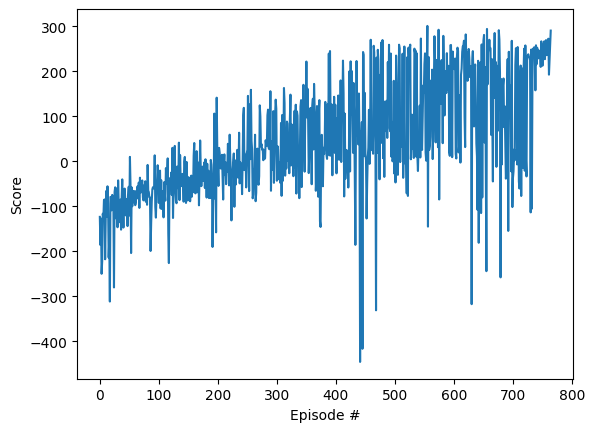

In [ ]:
plot_scores(episode_scores)

## Double DQN

In [ ]:
replay_memory = Replay_memory(env, BUFFER_SIZE, MIN_REPLAY_SIZE, BATCH_SIZE).initialize()

In [ ]:
dqn_policy = DQN(env.observation_space.shape[0], env.action_space.n)
dqn_target = DQN(env.observation_space.shape[0], env.action_space.n)
dqn_target.load_state_dict(dqn_policy.state_dict())
dqn_target.eval()

DQN(
  (a1): Linear(in_features=8, out_features=64, bias=True)
  (a2): Linear(in_features=64, out_features=4, bias=True)
)

In [ ]:
loss_fn = nn.SmoothL1Loss()
learning_rate = 0.001
optimizer = torch.optim.Adam(dqn_policy.parameters(), lr=learning_rate)

### Training

In [ ]:
obs, _ = env.reset()
eps_threshold = EPS_START
episode = 1
episode_scores = []

for step in itertools.count():
    action = epsilon_greedy_policy(eps_threshold, obs)
    new_obs, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    replay_memory.append(Transition(obs, action, reward, done, new_obs))
    episode_reward += reward
    obs = new_obs

    if done:
        episode += 1
        eps_threshold = np.max((eps_threshold*EPS_DECAY, EPS_END))
        replay_memory.rewards.append(episode_reward)
        episode_scores.append(episode_reward)
        obs, _ = env.reset()
        avg_res = np.mean(replay_memory.rewards)

        if episode % 100 == 0:
            print(f'Episode: {episode} Avg Results: {avg_res} Epsilon: {eps_threshold}')

        if avg_res >= 195:
            print(f'Solved at episode: {episode} Avg Results: {avg_res}')
            break
        episode_reward = 0

    b_states, b_actions, b_rewards, b_dones, b_next_states = replay_memory.sample_batch()

    qvalues = dqn_policy(b_states).gather(1, b_actions)

    with torch.no_grad():
        _, next_actions = dqn_policy(b_next_states).max(dim=1, keepdim=True)    # use dqn_policy to get actions in next state
        next_action_values = dqn_target(b_next_states).gather(1, next_actions)  # use dqn_target to get values of actions selected by dqn_policy

        expected_qvalues = b_rewards + GAMMA * (1 - b_dones.type(torch.int64)) * next_action_values

    loss = loss_fn(qvalues, expected_qvalues)
    optimizer.zero_grad()
    loss.backward()
    for param in dqn_policy.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

    if episode % TARGET_UPDATE_FREQ == 0:
        dqn_target.load_state_dict(dqn_policy.state_dict())

Episode: 100 Avg Results: -83.22935575583266 Epsilon: 0.6684411570569752
Episode: 200 Avg Results: -45.901302891245614 Epsilon: 0.49497015522925014
Episode: 300 Avg Results: 5.369265669340531 Epsilon: 0.3665176088892224
Episode: 400 Avg Results: 61.74180558654517 Epsilon: 0.2714005202266275
Episode: 500 Avg Results: 129.20065161168372 Epsilon: 0.2009678132587261
Episode: 600 Avg Results: 156.41044414600807 Epsilon: 0.14881350239221705
Episode: 700 Avg Results: 151.84390898467754 Epsilon: 0.11019405612842245
Episode: 800 Avg Results: 165.76103686279265 Epsilon: 0.08159696405794017
Episode: 900 Avg Results: 19.860292838343067 Epsilon: 0.06042126751113813
Episode: 1000 Avg Results: 147.742140980742 Epsilon: 0.05
Solved at episode: 1016 Avg Results: 197.74677061852464


In [ ]:
env = rl.RenderFrame(env, "./video")
build_video()

Moviepy - Building video temp-{start}.mp4.
Moviepy - Writing video temp-{start}.mp4



Moviepy - Done !
Moviepy - video ready temp-{start}.mp4


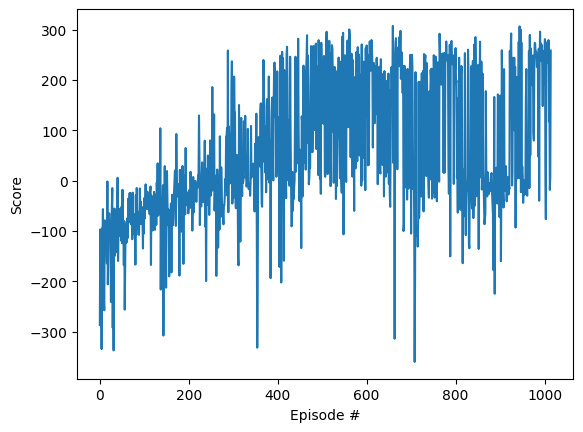

In [ ]:
plot_scores(episode_scores)

## Standard DQN with Priority Experience Replay

In [ ]:
Transition = namedtuple('Transition', ('states', 'actions', 'rewards', 'dones', 'next_states'))

class Replay_memory():

    def __init__(self, env, fullsize, minsize, batchsize):
        self.env = env
        self.memory = deque(maxlen=fullsize)
        self.rewards = deque(maxlen=50)
        self.batchsize = batchsize
        self.minsize = minsize

        self.priorities = deque(maxlen=fullsize)
        self.alpha = 0.6
        self.beta = 0.4
        self.max_priority = 0.0

    def append(self, transition):
        self.memory.append(transition)
        self.priorities.append(self.max_priority)

    def update(self, idxs, priorities):
        for idx, priority in zip(idxs, priorities):
            if priority > self.max_priority:
                self.max_priority = priority
            self.priorities[idx] = priority

    def sample_batch(self):
        len_buffer = len(self.memory)
        priorities = np.array(self.priorities, dtype=np.float64) + 0.0001
        priorities = priorities ** self.alpha
        probs = priorities / priorities.sum()
        weights = ((1/len_buffer) * (1/probs)) ** self.beta
        weights = weights / weights.max()
        idx = random.choices(range(len_buffer), weights=probs, k=self.batchsize)
        batch = [self.memory[i] for i in idx]

        batch = Transition(*zip(*batch))
        states = torch.from_numpy(np.array(batch.states, dtype=np.float32))
        actions = torch.from_numpy(np.array(batch.actions, dtype=np.int64)).unsqueeze(1)
        rewards = torch.from_numpy(np.array(batch.rewards, dtype=np.float32)).unsqueeze(1)
        dones = torch.from_numpy(np.array(batch.dones, dtype=np.bool8)).unsqueeze(1)
        next_states = torch.from_numpy(np.array(batch.next_states, dtype=np.float32))
        batch_weights = torch.from_numpy(np.array([weights[i] for i in idx], dtype=np.float32)).unsqueeze(1)

        return idx, batch_weights, states, actions, rewards, dones, next_states

    def initialize(self):
        obs, _ = env.reset()
        for _ in range(self.minsize):
            action = self.env.action_space.sample()
            new_obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            transition = Transition(obs, action, reward, done, new_obs)
            self.append(transition)
            obs = new_obs
            if done:
                self.env.reset()
        return self

In [ ]:
replay_memory = Replay_memory(env, BUFFER_SIZE, MIN_REPLAY_SIZE, BATCH_SIZE).initialize()

In [ ]:
dqn_policy = DQN(env.observation_space.shape[0], env.action_space.n)
dqn_target = DQN(env.observation_space.shape[0], env.action_space.n)
dqn_target.load_state_dict(dqn_policy.state_dict())
dqn_target.eval()

DQN(
  (a1): Linear(in_features=8, out_features=64, bias=True)
  (a2): Linear(in_features=64, out_features=4, bias=True)
)

In [ ]:
loss_fn = nn.SmoothL1Loss()
learning_rate = 0.001
optimizer = torch.optim.Adam(dqn_policy.parameters(), lr=learning_rate)

### Training

In [ ]:
obs, _ = env.reset()
eps_threshold = EPS_START
episode = 1
episode_scores = []

for step in itertools.count():
    action = epsilon_greedy_policy(eps_threshold, obs)
    new_obs, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    replay_memory.append(Transition(obs, action, reward, done, new_obs))
    episode_reward += reward
    obs = new_obs

    if done:
        episode += 1
        replay_memory.alpha *= 0.999
        replay_memory.beta *= 0.999
        eps_threshold = np.max((eps_threshold*EPS_DECAY, EPS_END))
        replay_memory.rewards.append(episode_reward)
        episode_scores.append(episode_reward)
        obs, _ = env.reset()
        avg_res = np.mean(replay_memory.rewards)

        if episode % 100 == 0:
            print(f'Episode: {episode} Avg Results: {avg_res} Epsilon: {eps_threshold}')

        if avg_res >= 195:
            print(f'Solved at episode: {episode} Avg Results: {avg_res}')
            break
        episode_reward = 0

    b_idx, b_weights, b_states, b_actions, b_rewards, b_dones, b_next_states = replay_memory.sample_batch()

    qvalues = dqn_policy(b_states).gather(1, b_actions)

    with torch.no_grad():
        target_qvalues = dqn_target(b_next_states)
        max_target_qvalues = torch.max(target_qvalues, axis=1).values.unsqueeze(1)
        expected_qvalues = b_rewards + GAMMA * (1 - b_dones.type(torch.int64)) * max_target_qvalues

    #update priorities
    tderrors = (qvalues - expected_qvalues).abs().detach().numpy().squeeze()
    replay_memory.update(b_idx, tderrors)

    loss = b_weights * loss_fn(qvalues, expected_qvalues)
    loss = loss.mean()

    optimizer.zero_grad()
    loss.backward()
    for param in dqn_policy.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

    if episode % TARGET_UPDATE_FREQ == 0:
        dqn_target.load_state_dict(dqn_policy.state_dict())

Episode: 100 Avg Results: -91.06095371963798 Epsilon: 0.6684411570569752
Episode: 200 Avg Results: -31.524868335639503 Epsilon: 0.49497015522925014
Episode: 300 Avg Results: 3.1112516498335014 Epsilon: 0.3665176088892224
Episode: 400 Avg Results: 41.10556150262747 Epsilon: 0.2714005202266275
Episode: 500 Avg Results: 149.1862864583259 Epsilon: 0.2009678132587261
Episode: 600 Avg Results: 151.92633913796539 Epsilon: 0.14881350239221705
Solved at episode: 659 Avg Results: 197.50334087897517


In [ ]:
env = rl.RenderFrame(env, "./video")
build_video()

Moviepy - Building video temp-{start}.mp4.
Moviepy - Writing video temp-{start}.mp4



Moviepy - Done !
Moviepy - video ready temp-{start}.mp4


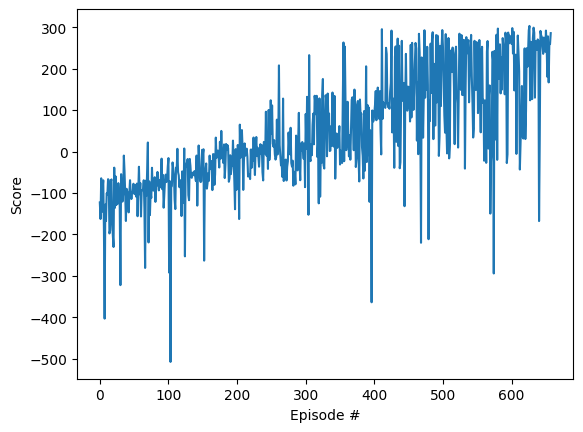

In [ ]:
plot_scores(episode_scores)

## Double DQN with Priority Experience Replay

In [ ]:
replay_memory = Replay_memory(env, BUFFER_SIZE, MIN_REPLAY_SIZE, BATCH_SIZE).initialize()

In [ ]:
dqn_policy = DQN(env.observation_space.shape[0], env.action_space.n)
dqn_target = DQN(env.observation_space.shape[0], env.action_space.n)
dqn_target.load_state_dict(dqn_policy.state_dict())
dqn_target.eval()

DQN(
  (a1): Linear(in_features=8, out_features=64, bias=True)
  (a2): Linear(in_features=64, out_features=4, bias=True)
)

In [ ]:
loss_fn = nn.SmoothL1Loss()
learning_rate = 0.001
optimizer = torch.optim.Adam(dqn_policy.parameters(), lr=learning_rate)

### Training

In [ ]:
obs, _ = env.reset()
eps_threshold = EPS_START
episode = 1
episode_scores = []

for step in itertools.count():
    action = epsilon_greedy_policy(eps_threshold, obs)
    new_obs, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    replay_memory.append(Transition(obs, action, reward, done, new_obs))
    episode_reward += reward
    obs = new_obs

    if done:
        episode += 1
        replay_memory.alpha *= 0.999
        replay_memory.beta *= 0.999
        eps_threshold = np.max((eps_threshold*EPS_DECAY, EPS_END))
        replay_memory.rewards.append(episode_reward)
        episode_scores.append(episode_reward)
        obs, _ = env.reset()
        avg_res = np.mean(replay_memory.rewards)

        if episode % 100 == 0:
            print(f'Episode: {episode} Avg Results: {avg_res} Epsilon: {eps_threshold}')

        if avg_res >= 195:
            print(f'Solved at episode: {episode} Avg Results: {avg_res}')
            break
        episode_reward = 0

    b_idx, b_weights, b_states, b_actions, b_rewards, b_dones, b_next_states = replay_memory.sample_batch()

    qvalues = dqn_policy(b_states).gather(1, b_actions)

    with torch.no_grad():
        _, next_actions = dqn_policy(b_next_states).max(dim=1, keepdim=True)    # use dqn_policy to get actions in next state
        next_action_values = dqn_target(b_next_states).gather(1, next_actions)  # use dqn_target to get values of actions selected by dqn_policy

        expected_qvalues = b_rewards + GAMMA * (1 - b_dones.type(torch.int64)) * next_action_values

    #update priorities
    tderrors = (qvalues - expected_qvalues).abs().detach().numpy().squeeze()
    replay_memory.update(b_idx, tderrors)

    loss = b_weights * loss_fn(qvalues, expected_qvalues)
    loss = loss.mean()

    optimizer.zero_grad()
    loss.backward()
    for param in dqn_policy.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

    if episode % TARGET_UPDATE_FREQ == 0:
        dqn_target.load_state_dict(dqn_policy.state_dict())

Episode: 100 Avg Results: -76.71704596858395 Epsilon: 0.6684411570569752
Episode: 200 Avg Results: -39.24666948174217 Epsilon: 0.49497015522925014
Episode: 300 Avg Results: -14.989019399078815 Epsilon: 0.3665176088892224
Episode: 400 Avg Results: 60.31653268928172 Epsilon: 0.2714005202266275
Episode: 500 Avg Results: 114.67967852259768 Epsilon: 0.2009678132587261
Episode: 600 Avg Results: 151.62657839417705 Epsilon: 0.14881350239221705
Solved at episode: 677 Avg Results: 198.44689932280903


In [ ]:
env = rl.RenderFrame(env, "./video")
build_video()

Moviepy - Building video temp-{start}.mp4.
Moviepy - Writing video temp-{start}.mp4



Moviepy - Done !
Moviepy - video ready temp-{start}.mp4


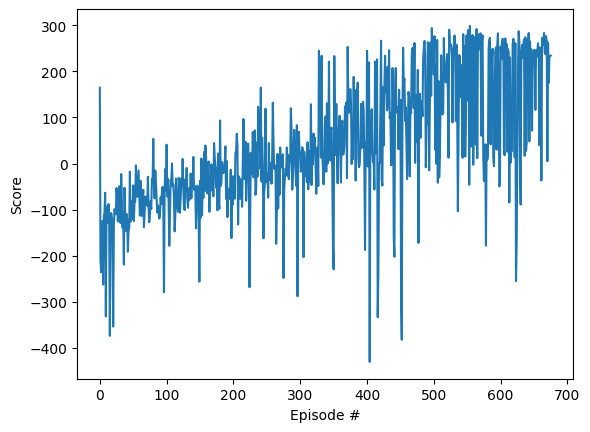

In [ ]:
plot_scores(episode_scores)